In [87]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt

import folium
from folium.plugins import MarkerCluster
import geopandas as gpd

import numpy as np

import gurobipy as gp
from gurobipy import GRB

In [89]:
# Data source: granted by SB Fire District GIS Manager
stations = gpd.read_file("Data/Fire_Stations_SBC.shp")

# Data source: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-county-santa-barbara-county-ca-topological-faces-polygons-with-all-ge
SLO = gpd.read_file("Data/CityLimit/CityLimit.shp")

In [91]:
shapefile = "Data/CityLimit/CityLimit.shp"
data = gpd.read_file(shapefile)

# Check the geometry type
print(data.geometry.geom_type.unique())

['Polygon']


In [93]:
SLO_shape = SLO.unary_union

In [95]:
stations.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [97]:
SLO.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

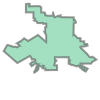

In [99]:
SLO_shape

In [101]:
SLO_shape.geom_type

'Polygon'

In [103]:
SLO.to_crs(stations.crs)

,OBJECTID,Acres,code,descriptio,label,zoneID,Shape__Are,Shape__Len,geometry
0,402,8824.456298,CityLimit,City Limit,City Limit,CityLimit,3.842904e+08,171731.843556,"POLYGON ((5758063.812 2287953.168, 5757987.668..."


In [104]:
SLO_shape = gpd.GeoDataFrame(geometry=[SLO.to_crs(stations.crs).unary_union], crs=stations.crs)
SLO_shape

,geometry
0,"POLYGON ((5758063.812 2287953.168, 5757987.668..."


In [107]:

import folium
from folium.plugins import MousePosition
import geopandas as gpd


SLO_shape_4326 = SLO_shape.to_crs(4326)

# Calculate the centroid of the polygon
centroid = SLO_shape_4326.geometry.centroid.values[0].coords[0]

# Create a Folium map centered at the centroid of the polygon
m = folium.Map(location=[centroid[1], centroid[0]], zoom_start=9)

# Add the polygon to the map
folium.GeoJson(SLO_shape_4326, style_function=lambda x: { 'fillColor': 'transparent'}).add_to(m)

folium.GeoJson(stations.to_crs(4326)).add_to(m)

# Add MousePosition control to display cursor coordinates
#### Use the cursor coordinates to define your Area of Interest! ####
MousePosition().add_to(m)

# Display the map 
m

/var/folders/hj/9p0zy4nd57bb7nrkx6qt6b0h0000gn/T/ipykernel_60971/412111619.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = SLO_shape_4326.geometry.centroid.values[0].coords[0]


In [109]:
max_x, min_x = -120.61751, -120.72842
max_y, min_y = 35.31173, 35.23264

# Create the rectangle geometry, which forms are study region boundary.
boundary = Polygon([(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y), (min_x, min_y)])

# Add the boundary to the map
folium.GeoJson(boundary.__geo_interface__, style_function=lambda x: {'color': 'red', 'fillColor': 'transparent'}).add_to(m)

m

In [111]:
boundary = gpd.GeoSeries(boundary, crs=4326).to_crs(stations.crs)[0]
boundary.area / 2.788e+7

34.183270331984396

In [113]:
stations.within(boundary)#.sum()

0      False
1      False
2      False
3      False
4      False
       ...  
203    False
204    False
205    False
206    False
207    False
Length: 208, dtype: bool

In [115]:
study_stations = stations.loc[stations.within(boundary)].reset_index(drop=True)
len(study_stations)

6

In [117]:
SLO_city_boundary = SLO_shape.intersection(boundary)
SLO_city_boundary

0    POLYGON ((5757987.668 2288030.745, 5757968.851...
dtype: geometry

95.42 % covered


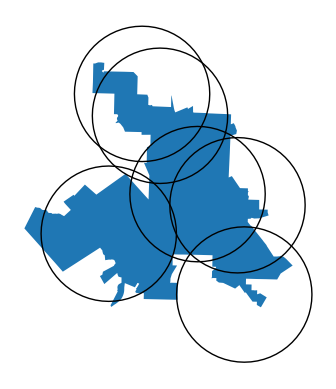

In [119]:
COVERAGE_DISTANCE = 1.5 * 5280 # because 1*5280 feet is 1 mile 

# Draw buffer from each fire station in study_stations GeoDataFrame 
    # Buffer distance is COVERAGE_DISTANCE we've defined
stations_coverage = study_stations.buffer(COVERAGE_DISTANCE) 

# Let's plot the county polgyon within our study region, and
    # stations_coverage buffers
A = stations_coverage.plot(facecolor="None")
SLO_city_boundary.plot(ax=A, zorder=-1)
plt.axis("off")

# How much area is covered?
    # To get to know, firstly take unary_union of the total station_coverage
total_stations_coverage = stations_coverage.unary_union
    # Then take the intersection with boundary_county, to exclude water area
total_stations_coverage = total_stations_coverage.intersection(SLO_city_boundary)
    # Then divide the area of the updated total_station_coverage with the boundary_county.area
coverage = total_stations_coverage.area / SLO_city_boundary.area
    # Multiply 100 to get the % value
coverage = coverage * 100

# Check out how much percentage of study region is covered by current fire stations.
    # Do they agree with each other? the coverage % and plot?
print(f'{round(coverage.values[0],2)} % covered')

In [120]:
redundant_coverage = 0
    # This two for-loops is the most efficient way to go through all 2 pair combinations of stations_coverage
for i in range(len(stations_coverage)-1):
    # Take one station coverage buffer
    cover_i = stations_coverage[i]
    
    for j in range(i+1, len(stations_coverage)):
        # Take another station coverage buffer which hasn't paired with i
        cover_j = stations_coverage[j]
        print("\t combination: ", i, j)
        
        # With the two stations combination, calculate the intersection area.
            # and sum up!
        redundant_coverage += cover_i.intersection(cover_j).area

print() # To add blank line
print("Redundant Coverage: ", redundant_coverage / 2.788e+7, " square miles")

	 combination:  0 1
	 combination:  0 2
	 combination:  0 3
	 combination:  0 4
	 combination:  0 5
	 combination:  1 2
	 combination:  1 3
	 combination:  1 4
	 combination:  1 5
	 combination:  2 3
	 combination:  2 4
	 combination:  2 5
	 combination:  3 4
	 combination:  3 5
	 combination:  4 5

Redundant Coverage:  15.659078470354734  square miles


In [121]:
def calculate_redundant_coverage(coverage_buffers):
    redundant_coverage = 0
        # This two for-loops is the most efficient way to go through all 2 pair combinations of stations_coverage
    for i in range(len(coverage_buffers)-1):
        # Take one station coverage buffer
        cover_i = coverage_buffers[i]

        for j in range(i+1, len(coverage_buffers)):
            # Take another station coverage buffer which hasn't paired with i
            cover_j = coverage_buffers[j]

            # With the two stations combination, calculate the intersection area.
                # and sum up!
            redundant_coverage += cover_i.intersection(cover_j).area

    print() # To add blank line
    print("Redundant Coverage: ", redundant_coverage / 2.788e+7, " square miles")
    return redundant_coverage / 2.788e+7

In [125]:
current_rc = calculate_redundant_coverage(stations_coverage)


Redundant Coverage:  15.659078470354734  square miles


In [127]:
boundary.bounds

(5746956.492602991, 2281159.019511844, 5780816.372835667, 2310816.202665041)

In [129]:
minx, miny, maxx, maxy = boundary.bounds
print(minx, miny, maxx, maxy)

5746956.492602991 2281159.019511844 5780816.372835667 2310816.202665041


Number of points in the fishnet: 957


<Axes: >

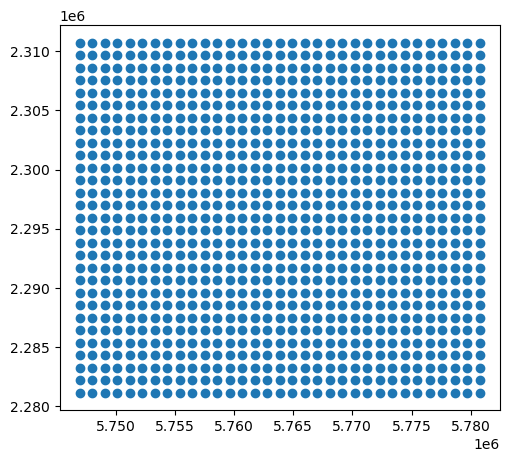

In [131]:
interval = 5280/5  # default: 5280/5 feet (1 mile / 5 = 0.2 mile) 


# Create arrays of x and y coordinates using np.arange
x_coords = np.arange(minx, maxx, interval)
y_coords = np.arange(miny, maxy, interval)

# Create a list to store the points
fishnet_points = []

# Generate points for the fishnet
for y in y_coords:
    for x in x_coords:
        fishnet_points.append((x, y))

# Print the number of points generated
print("Number of points in the fishnet:", len(fishnet_points))

fishnet_points = gpd.GeoSeries([Point(pt_cd) for pt_cd in fishnet_points])
fishnet_points.plot(figsize=(15,5))

<Axes: >

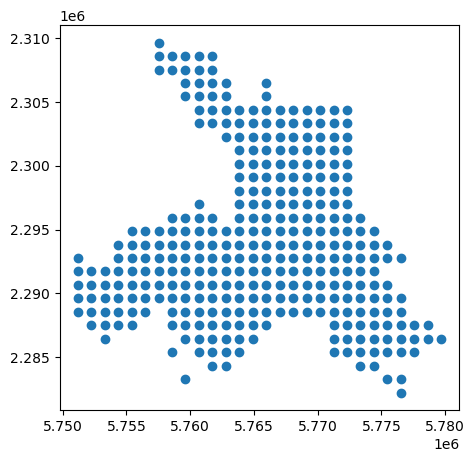

In [133]:
fishnet_points = fishnet_points.loc[fishnet_points.intersects(SLO_city_boundary[0])]
fishnet_points = fishnet_points.loc[fishnet_points.intersects(total_stations_coverage[0])].reset_index(drop=True)

fishnet_points.plot(figsize=(15,5))

<Axes: >

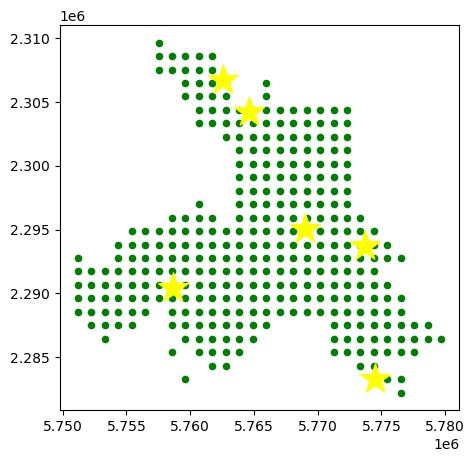

In [134]:
A = fishnet_points.plot(figsize=(15,5), color="Green", markersize=20)
study_stations.plot(ax=A, color="Yellow", marker="*", markersize=500)

In [137]:
num_demands = len(fishnet_points) 
num_facilities = len(study_stations)

D_ij = [[np.sqrt((fishnet_points.x[i] - study_stations.geometry.x[j])**2 + (fishnet_points.y[i] - study_stations.geometry.y[j])**2) 
         for j in range(num_facilities)] for i in range(num_demands)]

N_i = dict(zip(range(num_demands), [[] for _ in range(num_demands)]))

for i in range(num_demands):
    for j in range(num_facilities):
        if D_ij[i][j] <= COVERAGE_DISTANCE:
            N_i[i].append(j)

# Create a new model
model = gp.Model("LSCP")

# Decision variables
# x[i] = 1 if facility i is selected, 0 otherwise
x = model.addVars(num_facilities, vtype=GRB.BINARY, name="x")

# Objective function: minimize the number of selected facilities
model.setObjective(gp.quicksum(x[j] for j in range(num_facilities)), GRB.MINIMIZE)

# Constraints
# Each demand point must be covered by at least one selected facility
for i in range(num_demands):
    model.addConstr(gp.quicksum(x[j] for j in N_i[i]) >= 1, name=f"cover_demand_point_{j}")

# Optimize the model
model.optimize()


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 21.3.0 21D62)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 330 rows, 6 columns and 571 nonzeros
Model fingerprint: 0xf9e1bbfa
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 330 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%


In [138]:
selected_bool = [x[i].x > 0.5 for i in range(num_facilities)]
selected_facilities = study_stations.loc[selected_bool].reset_index(drop=True)
unselected_facilities = study_stations.loc[~np.array(selected_bool)].reset_index(drop=True)

print("Objective value: ", model.objVal, sum(selected_bool))
print("Current running stations: ", len(study_stations))


Objective value:  5.0 5
Current running stations:  6


(5749139.984296548, 5784007.269354798, 2273406.3507871116, 2316657.7444396666)

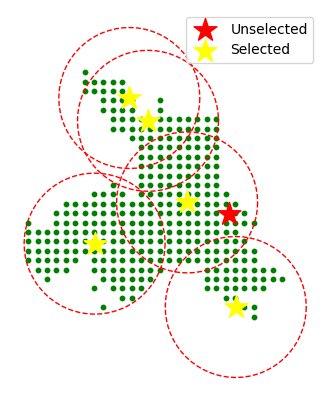

In [139]:
A = gpd.GeoSeries(MultiPoint(fishnet_points)).plot(figsize=(15,5), color="green", markersize=10)
unselected_facilities.plot(ax=A, color="red", legend=True, label="Unselected", marker="*", markersize=300, zorder=10)
selected_facilities.plot(ax=A, color="yellow", marker="*", markersize=300, legend=True, label="Selected")
selected_facilities.buffer(COVERAGE_DISTANCE).plot(ax=A, edgecolor="red", facecolor="None", linestyle="dashed")
plt.legend()
plt.axis("off")

In [142]:
# Convert GeoPandas GeoSeries to GeoDataFrame
fishnet_gdf = gpd.GeoDataFrame(geometry=fishnet_points, crs=stations.crs).to_crs(4326)

# Create a base map
m = folium.Map(location=[fishnet_gdf.unary_union.centroid.y, fishnet_gdf.unary_union.centroid.x], zoom_start=11)



# Plot fishnet
for idx, row in fishnet_gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x],
                        radius=1,
                        color='grey', fillcolor="grey").add_to(m)

# Plot study stations
for idx, row in unselected_facilities.to_crs(4326).iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x],
                   icon=folium.Icon(color='blue'),
                   popup=row['Label']).add_to(m)

# Plot selected facilities
for idx, row in selected_facilities.to_crs(4326).iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x],
                   icon=folium.Icon(color='red', icon='star'),
                   popup=row['Label']).add_to(m)

# Plot buffer around selected facilities
for idx, row in selected_facilities.to_crs(4326).iterrows():
    folium.vector_layers.Circle(location=[row.geometry.y, row.geometry.x],
                                 radius=COVERAGE_DISTANCE/3.281, # feet to meter conversion
                                 color='red',
                                 fill=False,
                                 dash_array='10').add_to(m)

# Display the map
m

In [144]:
! pip install nbconvert==6.0.0 

In [146]:
current_rc

15.659078470354734

In [147]:
optimized_rc = calculate_redundant_coverage(selected_facilities.buffer(COVERAGE_DISTANCE))


Redundant Coverage:  9.333334204501462  square miles


In [148]:
# Let's create the spatial efficienty

# Minimum (ideal) number of facilities needed to cover the demands covered by current facilities
# divided by the number of current facilities (fire stations).

spatial_efficiency = model.objVal / len(study_stations) * 100

print("Spatial Efficienty is ", round(spatial_efficiency, 2), " %")

# Higher efficienty, closer to the ideal number
# Lower efficienty, more redundancy, further from the ideal number

Spatial Efficienty is  83.33  %


In [149]:
print("Coverage Distance (mi): " , COVERAGE_DISTANCE / 5280) # Double Check this value before putting into table ** 
print("Current Stations #: " ,len(study_stations))
print("Optimized Stations #: ", len(selected_facilities))
print("Current Redundant Coverage (sqmi): ", current_rc)
print("Optimized Redundant Coverage (sqmi): ", optimized_rc)
print("Spatial Efficiency (%): ", spatial_efficiency)

Coverage Distance (mi):  1.5
Current Stations #:  6
Optimized Stations #:  5
Current Redundant Coverage (sqmi):  15.659078470354734
Optimized Redundant Coverage (sqmi):  9.333334204501462
Spatial Efficiency (%):  83.33333333333334
